In [1]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks')
from multiclass_functions2 import * # my module import
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets,transforms
import numpy as np
import matplotlib.pyplot as plt
import copy
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

Mounted at /content/drive


In [2]:
# BATCH_SIZE = 512
# BATCH_SIZE = 256
# BATCH_SIZE = 128
BATCH_SIZE = 64
# BATCH_SIZE = 32
# BATCH_SIZE = 16
# LR = 1e-2
# LR = 4e-3
# LR = 2e-3
LR = 1e-3
# LR = 1e-4
# LR = 1e-5
EPOCH = 10
DROP_P = 0.9
# DROP_P = 0.5
# DROP_P = 0.1
# DROP_P = 0
criterion = nn.MSELoss()
new_model_Train = False
model_type = f"AE_{DROP_P}"
save_model_path = f"/content/drive/MyDrive/Colab Notebooks/results/Dropout/{model_type}_MNIST.pt"

In [3]:
transform_train = transforms.Compose([
    transforms.ToTensor(),

    # transforms.RandomResizedCrop(size=(28,28), scale=(0.8,1), ratio=(0.75,1.3)),
    # random하게 자른 다음에 resize라서 RandomCrop과 다름
    # scale은 어느 정도로 작은 범위를 자를지 (0~1 사이 값)
    # ratio는 aspect ratio로, 가로 길이/세로 길이 를 의미한다.

    # transforms.RandomHorizontalFlip(p=0.3), # p 확률로 좌우반전
    # transforms.RandomVerticalFlip(p=0.3), # p 확률로 상하반전
    # transforms.RandomAffine(degrees=(0,90),translate=(0.1,0.3),scale=(0.9,1.1)),
    # translate는 이동하는 정도 (비율), scale은 크기 조절
    # transforms.RandomPerspective(distortion_scale=0.1, p=0.2), # distortion 정도 0~1 사이, default는 0.5, p는 적용 확률
    ])
transform_test = transforms.Compose([transforms.ToTensor()])

transform = transforms.ToTensor()
train_DS = datasets.MNIST(root = '/content/drive/MyDrive/Colab Notebooks/data', train=True, download=True, transform=transform_train)
test_DS = datasets.MNIST(root = '/content/drive/MyDrive/Colab Notebooks/data', train=False, download=True, transform=transform_test)
train_DL = torch.utils.data.DataLoader(train_DS, batch_size=BATCH_SIZE, shuffle=True)
test_DL = torch.utils.data.DataLoader(test_DS, batch_size=BATCH_SIZE, shuffle=False)

x_batch size = torch.Size([64, 1, 28, 28])
x_batch size = torch.Size([64, 1, 28, 28])


torch.Size([64, 1, 28, 28])

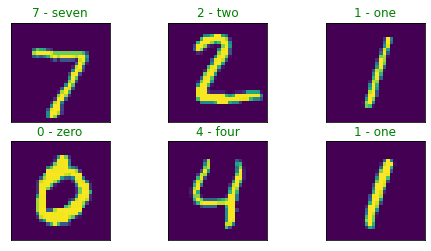

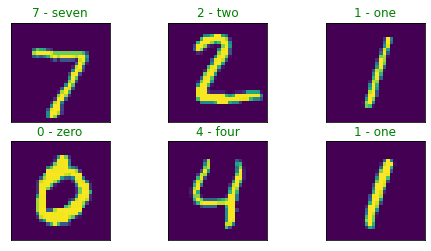

In [4]:
test_DS_wT = copy.deepcopy(test_DS)
test_DS_wT.transform = transform_train
test_DL_wT = torch.utils.data.DataLoader(test_DS_wT, batch_size = BATCH_SIZE, shuffle = False)
im_plot(test_DL)
im_plot(test_DL_wT)

x, _ = next(iter(test_DL_wT))
x.shape

In [5]:
def Train(model, train_DL, criterion):
    optimizer=optim.Adam(model.parameters(), lr=LR)

    NoT=len(train_DL.dataset) # Number of training data
    loss_history = []

    model.train() # train mode로!

    for ep in range(EPOCH):
        rloss = 0
        for x_batch, _ in train_DL:
            x_batch = x_batch.to(DEVICE)
            # inference
            y_hat = model(x_batch)
            # cross entropy loss
            loss = criterion(y_hat, x_batch)
            # update
            optimizer.zero_grad() # gradient 누적을 막기 위함
            loss.backward() # backpropagation
            optimizer.step() # weight update
            # loss accumulation
            loss_b = loss.item() * x_batch.shape[0] # batch loss # BATCH_SIZE 로 하면 마지막 16개도 32개로 계산해버림
            rloss += loss_b # running loss
        # print loss
        loss_e = rloss/NoT # epoch loss
        loss_history += [loss_e]
        print("Epoch:", ep+1, "train loss:", round(loss_e,3) )
        print("-"*20)
            
    return loss_history

def Test_plot(model,test_DL):
    model.eval()
    with torch.no_grad():
        x_batch, _ = next(iter(test_DL))
        x_batch = x_batch.to(DEVICE)
        y_hat = model(x_batch)

    x_batch = x_batch.to("cpu")
    y_hat = y_hat.to("cpu")

    plt.figure(figsize=(8,4))
    plt.figure(figsize=(8,4))
    for idx in range(6):
        plt.figure(1)
        plt.subplot(2,3, idx+1, xticks=[], yticks=[])
        plt.imshow(x_batch[idx,...].permute(1,2,0).squeeze(), cmap="gray")
        plt.figure(2)
        plt.subplot(2,3, idx+1, xticks=[], yticks=[])
        plt.imshow(y_hat[idx,...].permute(1,2,0).squeeze(), cmap="gray")

def feature_map_plot(model):
    plt.figure(figsize=(16,16))
    with torch.no_grad():
        for idx in range(256):
            feature_map = model.fcs[0].weight[idx,:]
            feature_map = feature_map.reshape(1,28,28)
            plt.subplot(16,16, idx+1, xticks=[], yticks=[])
            plt.imshow(feature_map.permute(1,2,0).squeeze(), cmap="gray")

# def feature_map_plot2(model, DL):
#     x_batch, _ = next(iter(test_DL))
#     model.eval()
#     with torch.no_grad():
#         x = torch.flatten(x_batch[0], start_dim=1)
#         x = model.fcs[0:3](x)
        
#         plt.figure(figsize=(16,16))
#         for idx in range(256):
#             feature_map = x[0,idx]*model.fcs[3].weight[:,idx]
#             feature_map = feature_map.reshape(1,28,28)
#             plt.subplot(16,16, idx+1, xticks=[], yticks=[])
#             plt.imshow(feature_map.permute(1,2,0).squeeze(), cmap="gray")

In [6]:
class AE(nn.Module):
    def __init__(self):
        super().__init__()
        self.fcs = nn.Sequential(nn.Linear(28*28, 256, bias = False),
                                 nn.ReLU(),
                                 nn.Dropout(p=DROP_P),
                                 nn.Linear(256, 28*28, bias = False))
    def forward(self,x):
        x = torch.flatten(x, start_dim=1)
        x = self.fcs(x)
        x = x.reshape(-1,1,28,28)
        return x

In [7]:
model=AE().to(DEVICE)
# print(model)
print(model(torch.randn(64,1,28,28).to(DEVICE)).shape)

torch.Size([64, 1, 28, 28])


In [8]:
if new_model_Train:
    loss_history = Train(model, train_DL, criterion)

    torch.save(model, save_model_path)

    plt.figure()
    plt.title("Train Loss")
    plt.plot(range(1,EPOCH+1),loss_history)
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.grid()

In [9]:
load_model = torch.load(save_model_path, map_location=DEVICE)

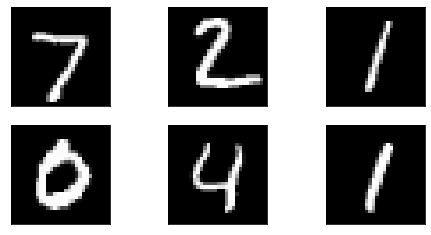

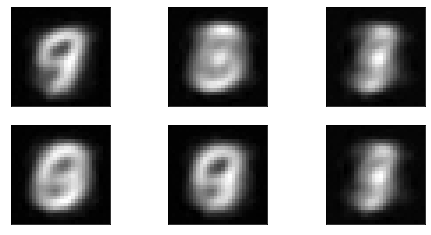

In [10]:
Test_plot(load_model,test_DL)

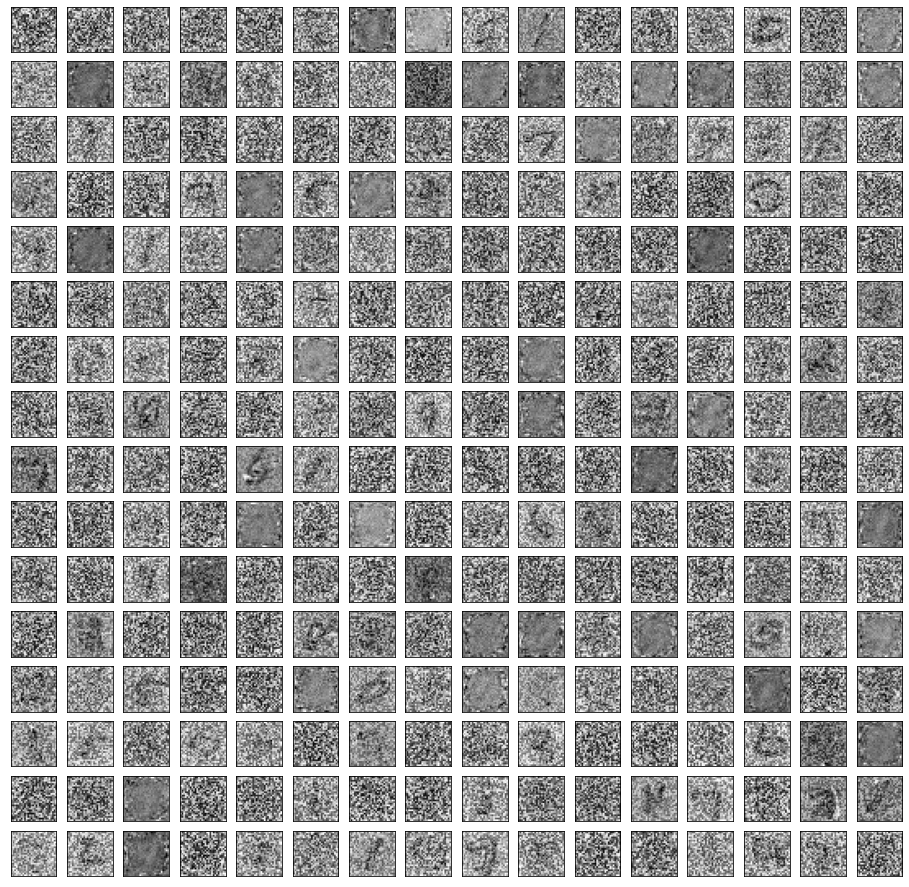

In [11]:
# load_model.fcs[0].weight[0,:].shape
load_model = load_model.to("cpu")
feature_map_plot(load_model)

# feature_map_plot2(load_model,test_DL)